To Do:
1. Explore the Titanic dataset

2. Train a Logistic Regression classification model

3. Feature engineering

4. Calculate the train and validation accuracy

5. Train a Random Forest classification model

6. Calculate accuracy using Confusion Matrix

7. Submit the predictions to Kaggle

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve, auc, roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

# Read the Data

In [49]:
df = pd.read_csv('train.csv')

# EDA

### Remove 'Ticket', 'PassengerId','Cabin'

In [50]:
df.drop(['PassengerId','Ticket'], axis=1, inplace=True)

### Convert Names & Cabin to their character length

In [51]:
df['Name'] = df['Name'].str.len()
df['Cabin'] = df['Cabin'].str.len()

### Pclass vs Survived

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

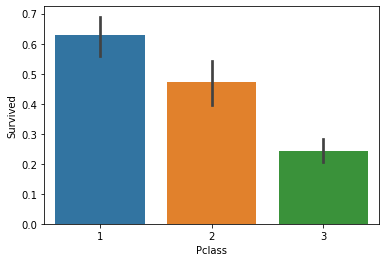

In [52]:
sns.barplot(x='Pclass', y='Survived', data=df)

### Embarked vs Survived

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

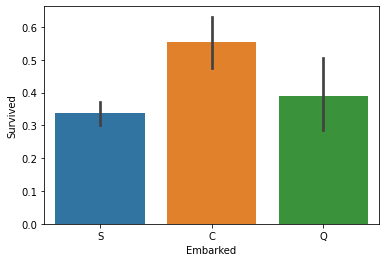

In [53]:
sns.barplot(x='Embarked', y='Survived', data=df)

### Check Correlations

<AxesSubplot:>

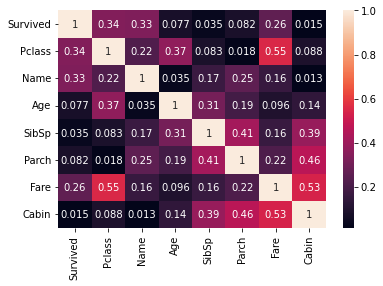

In [54]:
sns.heatmap(df.corr().abs(),annot=True)

### Check missing cells

<AxesSubplot:>

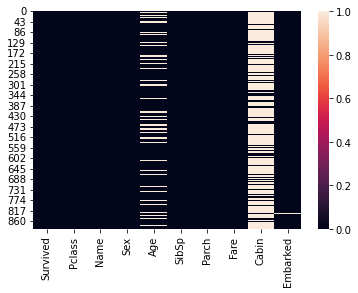

In [55]:
sns.heatmap(df.isna())

# Using Pipeline for categorizing numeric and categorical features

In [56]:
numeric_features = ['Name', 'Fare','Age','Cabin']
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), 
    RobustScaler()
    )

In [57]:
categorical_features = ['Embarked', 'Sex','Pclass']
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OneHotEncoder(handle_unknown="ignore")
    )

### Pre-Process transformations

In [58]:
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat',categorical_transformer, categorical_features),
                  ('do_nothing', 'passthrough',['Parch','SibSp'])])

# Select target and features

In [59]:
X = df.iloc[:,1:]
y = df['Survived']

# Split data into train and test sets

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

In [61]:
X_train.shape, X_test.shape

((534, 9), (357, 9))

# A. Modelling with 'LogisticRegression'

In [62]:
pipeline_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=100))

### Fit the train data with 'LogisticRegression'

In [63]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Name', 'Fare', 'Age',
                                                   'Cabin']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='

# Calculate a cross-validation score with 5 folds

In [64]:
cv_lr = cross_validate(pipeline_lr, X_train, y_train,
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv_lr = pd.DataFrame(cv_lr)
print(cv_lr)

   fit_time  score_time  test_score  train_score
0  0.085230    0.024724    0.859813     0.803279
1  0.033056    0.010453    0.822430     0.807963
2  0.025385    0.007026    0.728972     0.831382
3  0.021228    0.006912    0.766355     0.840749
4  0.024501    0.006180    0.849057     0.796729


In [65]:
cv_lr.mean()

fit_time       0.037880
score_time     0.011059
test_score     0.805325
train_score    0.816020
dtype: float64

# Calculate the train and test accuracy

In [66]:
print('train acc', round(pipeline_lr.score(X_train, y_train), 3))
print('test acc ', round(pipeline_lr.score(X_test, y_test), 3))

train acc 0.813
test acc  0.79


# Calculate precision and recall

In [67]:
ypred_lr = pipeline_lr.predict(X_test)

In [68]:
accuracy_score(y_test,ypred_lr) 

0.7899159663865546

In [69]:
precision = precision_score(y_test,ypred_lr)
recall = recall_score(y_test,ypred_lr)

print('precision:', precision_score(y_test,ypred_lr), '     recall:',round(recall_score(y_test,ypred_lr),4))

precision: 0.775      recall: 0.6596


# Confusion Matrix

In [70]:
conf_mat_lr = confusion_matrix(y_test,ypred_lr)
conf_mat_lr

array([[189,  27],
       [ 48,  93]])

<AxesSubplot:title={'center':'Confusion Matrix'}>

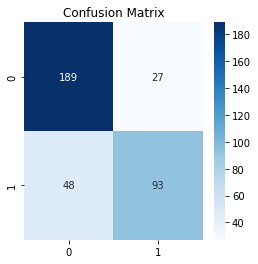

In [72]:
#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

sns.heatmap(conf_mat_lr, annot=True, ax = ax, fmt='g', cmap = 'Blues')

# Receiver Operator Curve and Area Under the Curve

In [73]:
probs_lr = pipeline_lr.predict_proba(X_test) 
fpr, tpr, threshold = roc_curve(y_test, probs_lr[:,1])

Area under the curve =  0.8458760178618335


(0.0, 1.0)

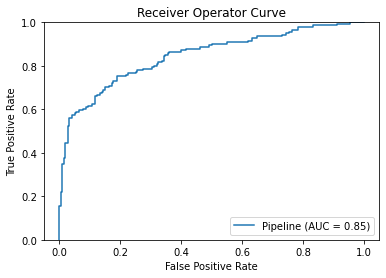

In [74]:
# Calculating area under the curve
auc_score = auc(fpr, tpr)
print("Area under the curve = ",auc_score)

plot_roc_curve(pipeline_lr, X_test, y_test)  
plt.title("Receiver Operator Curve")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.ylim([0,1.00])

# Precision Recall Curve

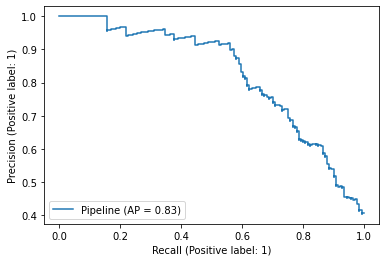

In [75]:
plot_precision_recall_curve(pipeline_lr, X_test, y_test)

In [76]:
precisions, recalls, thresholds = precision_recall_curve(y_test, probs_lr[:,1])

# Area under precision recall curve 

In [77]:
pr_area = auc(recalls, precisions)
pr_area

0.8243833351028006

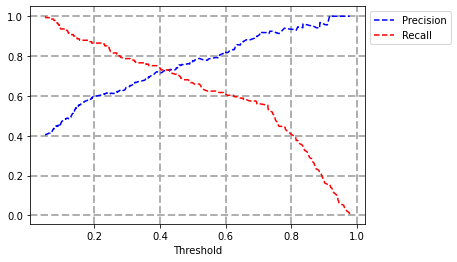

In [78]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(linestyle='--', linewidth=2)
plt.show()

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------

# B. Train with Random Forest classification model

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier

In [80]:
pipeline_rf = make_pipeline(preprocessor, RandomForestClassifier(max_depth= 5))

# Fit the train data with 'Random Forest'

In [81]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Name', 'Fare', 'Age',
                                                   'Cabin']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='

In [82]:
print('train acc', round(pipeline_rf.score(X_train, y_train), 3))
print('test acc ', round(pipeline_rf.score(X_test, y_test), 3))

train acc 0.873
test acc  0.798


# Calculate a cross-validation score with 5 folds

In [83]:
from sklearn.model_selection import cross_validate

cv_rf = cross_validate(pipeline_rf, X_train, y_train,
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv_rf = pd.DataFrame(cv_rf)
print(cv_rf)

   fit_time  score_time  test_score  train_score
0  0.209574    0.018484    0.869159     0.882904
1  0.162133    0.018369    0.831776     0.887588
2  0.173980    0.019559    0.785047     0.878220
3  0.175044    0.027853    0.785047     0.903981
4  0.169472    0.018366    0.877358     0.871495


In [84]:
cv_rf.mean()

fit_time       0.178041
score_time     0.020526
test_score     0.829677
train_score    0.884838
dtype: float64

# Calculate the train and test accuracy

In [37]:
print('train acc', round(pipeline_rf.score(X_train, y_train), 3))
print('test acc ', round(pipeline_rf.score(X_test, y_test), 3))

train acc 0.878
test acc  0.801


# Calculate precision and recall

In [38]:
ypred_rf = pipeline_rf.predict(X_test)

In [39]:
accuracy_score(y_test,ypred_rf) 

0.8011204481792717

In [40]:
precision = precision_score(y_test,ypred_rf)
recall = recall_score(y_test,ypred_rf)

print('precision:', precision_score(y_test,ypred_rf), '     recall:',round(recall_score(y_test,ypred_rf),4))

precision: 0.8125      recall: 0.6454


# Confusion Matrix

In [41]:
conf_mat_rf = confusion_matrix(y_test,ypred_rf)
conf_mat_rf

array([[195,  21],
       [ 50,  91]])

<AxesSubplot:title={'center':'Confusion Matrix'}>

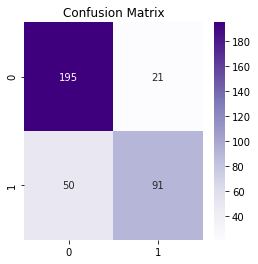

In [42]:
#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

sns.heatmap(conf_mat_rf, annot=True, ax = ax, fmt='g', cmap = 'Purples')

# Receiver Operator Curve and Area Under the Curve

In [43]:
probs_rf = pipeline_rf.predict_proba(X_test) 
fpr, tpr, threshold = roc_curve(y_test, probs_rf[:,1])

Area under the curve =  0.8611275282374572


(0.0, 1.0)

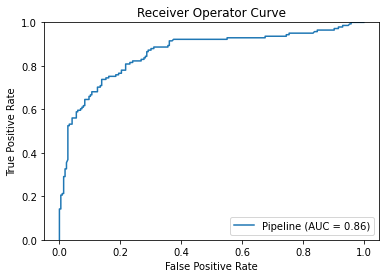

In [44]:
# Calculating area under the curve
auc_score = auc(fpr, tpr)
print("Area under the curve = ",auc_score)

plot_roc_curve(pipeline_rf, X_test, y_test)  
plt.title("Receiver Operator Curve")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.ylim([0,1.00])

# Precision Recall Curve

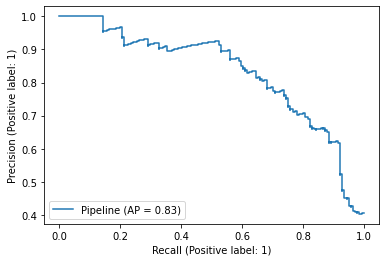

In [45]:
plot_precision_recall_curve(pipeline_rf, X_test, y_test)

In [46]:
precisions, recalls, thresholds = precision_recall_curve(y_test, probs_rf[:,1])

# Area under precision recall curve 

In [47]:
pr_area = auc(recalls, precisions)
pr_area

0.830942495113665

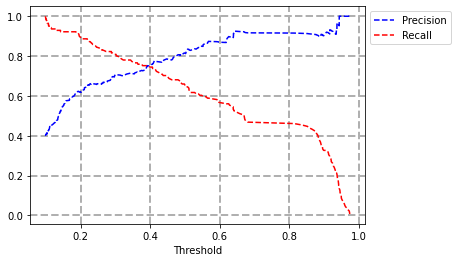

In [48]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(linestyle='--', linewidth=2)
plt.show()

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------

# Compare accuracy between 'Random Forest' & 'LogisticRegression' on test data

In [49]:
logistic_regression_test_accu = round(pipeline_lr.score(X_test, y_test), 3)
random_forest_train_accu = round(pipeline_rf.score(X_test, y_test), 3)

Serie = {'LogisticRegression_test': logistic_regression_test_accu,'RandomForest_test':random_forest_train_accu}
pd.Series(Serie, index=['LogisticRegression_test', 'RandomForest_test'])

LogisticRegression_test    0.790
RandomForest_test          0.801
dtype: float64

<AxesSubplot:title={'center':'Confusion Matrix-rf'}>

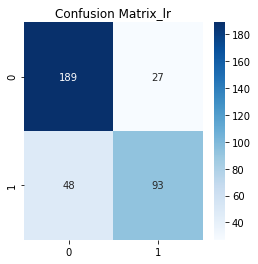

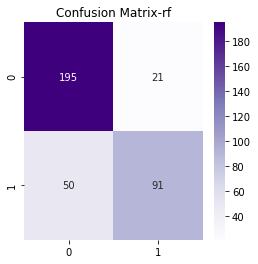

In [57]:
#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels_lr')
ax.set_ylabel('True labels_lr')
ax.set_title('Confusion Matrix_lr')
sns.heatmap(conf_mat_lr, annot=True, ax = ax, fmt='g', cmap = 'Blues')

#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels_rf')
ax.set_ylabel('True labels_rf')
ax.set_title('Confusion Matrix-rf')
sns.heatmap(conf_mat_rf, annot=True, ax = ax, fmt='g', cmap = 'Purples')

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------

# Predict on new test data with 'Random Forest' & 'LogisticRegression'

In [58]:
df_test = pd.read_csv('test.csv')

## Exploratory Data Analysis on TEST DATA

In [59]:
df_test.drop(['Ticket'], axis=1, inplace=True)
df_test['Name'] = df_test['Name'].str.len()
df_test['Cabin'] = df_test['Cabin'].str.len()
pred_log_reg_lr=df_test[['PassengerId']]
pred_log_reg_rf=df_test[['PassengerId']]
del df_test['PassengerId']

## Prediction by LogistisRegression

In [60]:
test_pred_lr = pipeline_lr.predict(df_test)

## Prediction by RandomForest

In [61]:
test_pred_rf = pipeline_rf.predict(df_test)

In [62]:
pred_log_reg_lr['Survived']=test_pred_lr

<ipython-input-62-12cc404ff01c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_log_reg_lr['Survived']=test_pred_lr


In [63]:
pred_log_reg_rf['Survived']=test_pred_rf

<ipython-input-63-d40e7ad9b60d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_log_reg_rf['Survived']=test_pred_rf


# Export predictions as .csv files to upload on Kaggle

In [64]:
pred_log_reg_lr.to_csv('Survived_lr.csv', index=False)

In [65]:
pred_log_reg_rf.to_csv('Survived_rf.csv', index=False)